# Duffing oscillator


We consider the following nonlinear ODE

$$
\ddot{x} = x - x^3 - \delta\dot{x} + \gamma \operatorname{cos} (\omega t),
$$

We will analyze the behavior near the fixed point $(x, \dot{x}) = (1, 0)$.

In [435]:
import sympy as sy
time, x, xdot, delta = sy.symbols('t x_1 x_2 \\delta')

from sympy import latex
from IPython.display import display_latex

def disp(idx, symObj):
    eqn = '\\[' + idx + ' ' + latex(symObj) + '\\]'
    display_latex(eqn,raw=True)
    return

In first order form, the vector field reads

In [436]:
RHS = sy.Matrix([xdot, x-x**3 - delta*xdot])
disp('\\frac{d}{dt}\\begin{pmatrix}x_1 \\\ x_2 \\end{pmatrix}=',RHS)

Its Jacobian at the fixed point is


In [490]:
J = RHS.jacobian([x, xdot]).subs([(x, 1), (xdot, 0)])
disp('J=', J)

which has eigenvalues

In [491]:
eigenvals = J.eigenvals(multiple = True)
for e in eigenvals:
    disp('\\lambda = ', e)

In the following, we fix the damping $\delta = 0.1$, 

$$
\lambda = −0.05\pm1.41332940251026𝑖
$$

In [439]:
# INPUT delta
deltaa=0.1
RHS.subs(delta, deltaa)

Matrix([
[                    x_2],
[-x_1**3 + x_1 - 0.1*x_2]])

In [440]:
vectorfield = sy.lambdify([time, [x, xdot]], RHS.subs(delta, deltaa))

In [441]:
def vectorfield(t,x):
    return np.array([x[1], x[0]-x[0]**3 - deltaa*x[1]])

In [442]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, least_squares
import ssmlearnpy.reduced_dynamics.normalform as normalform
from ssmlearnpy.utils import ridge
from ssmlearnpy.reduced_dynamics.shift_or_differentiate import shift_or_differentiate
from scipy.io import savemat, loadmat

We choose two initial conditions in the basin of attraction of (1, 0) and integrate them in time numerically. 

In [504]:
# INPUT time horizon and initial condition 
t = np.linspace(0, 100, 1001)
dt = t[1] - t[0]
ic_0 = np.array([0.1, 0])
ic_1 = np.array([0.32, .1])

sol_0 = solve_ivp(vectorfield, [t[0], t[-1]], ic_0, t_eval=t)
sol_1 = solve_ivp(vectorfield, [t[0], t[-1]], ic_1, t_eval=t)
trajectories = [sol_0.y - np.array([1,0]).reshape(-1,1), sol_1.y - np.array([1,0]).reshape(-1,1)]
times = [t, t]

In [507]:
xx = np.linspace(-1.5, 1.5, 30)
yy = np.linspace(-1.5, 1.5, 30)
X, Y = np.meshgrid(xx, yy)
grid = np.vstack((X.ravel(), Y.ravel()))
U, V = vectorfield(0, grid)
U = U.reshape(X.shape)
V = V.reshape(X.shape)


# Plot exact solution from numerical integration

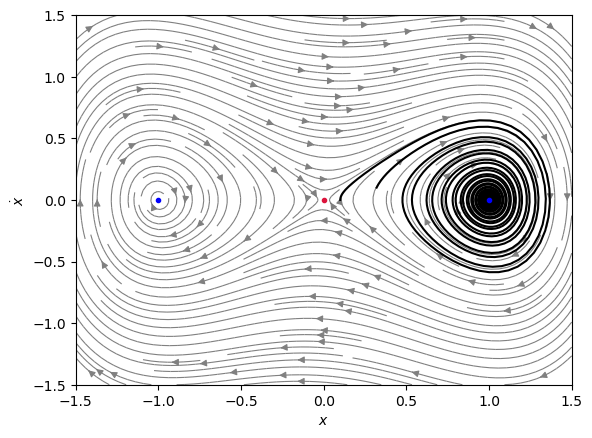

In [508]:
plt.streamplot(X, Y, U, V, color='grey', linewidth = 0.8, density = 2)
plt.xlabel('$x$')
plt.ylabel('$\\dot{x}$')

for t in trajectories:
    plt.plot(t[0,:]+1, t[1,:], '-', c='black')
plt.plot(0,0, '.', c='crimson')
plt.plot(1,0, '.', c='blue')
plt.plot(-1,0, '.', c='blue')


## Order 3 fit using SSMlearnpy

In [465]:
polyDeg=5
ndofs = 1

X, y  = shift_or_differentiate(trajectories, times, 'flow') 
# get an estimate for the linear part
# add the constraints to the fixed points explicitly
constLHS = [[-1, 0]]
constRHS = [[0, 0]]
cons = [constLHS, constRHS]
# Fit reduced model
mdl_const = ridge.get_fit_ridge(X, y, poly_degree = polyDeg, constraints = cons)
linearPart_const = mdl.map_info['coefficients'][:,:2]
mdl = ridge.get_fit_ridge(X, y, poly_degree = polyDeg)
linearPart = mdl.map_info['coefficients'][:,:2]

In [466]:
mdl.predict([[-1, 0]])

array([[-8.02934851e-05, -1.00252844e-04]])

In [467]:
mdl_const.predict([[-1, 0]])

array([[-3.10878602e-13, -3.90640645e-13]])

In [468]:
nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = polyDeg)
initial_guess = normalform.create_normalform_initial_guess(mdl, nf)

np.random.seed(3)
res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')
d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)

In the following, we fix the damping $\delta = 0.1$, 

$$
\lambda = −0.05\pm1.41332940251026𝑖
$$

With a 3rd order initial fit, the estimated linear part is accurate to within ~3%.

In [469]:
nf.LinearPart[1,1]

(-0.04764872410176884-1.409953004018975j)

In [470]:
trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, polyDeg, d )

The trajectories can be plotted in the normal form coordinates

In [471]:
trajectories[0].shape

(2, 1000)

Text(0.5, 1.0, 'Exact trajectories')

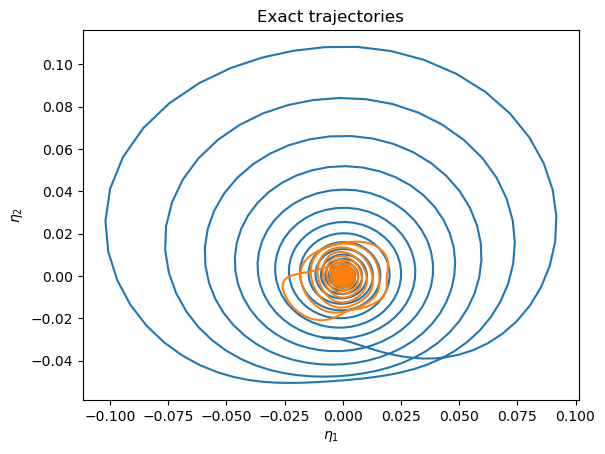

In [472]:
for t in trajectories:
    transformed = trf.inverse_transform(t) 
    plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]))
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.title('Exact trajectories')

In [473]:
time_pred = np.linspace(0, 100, 1000)
dt = t[1] - t[0]

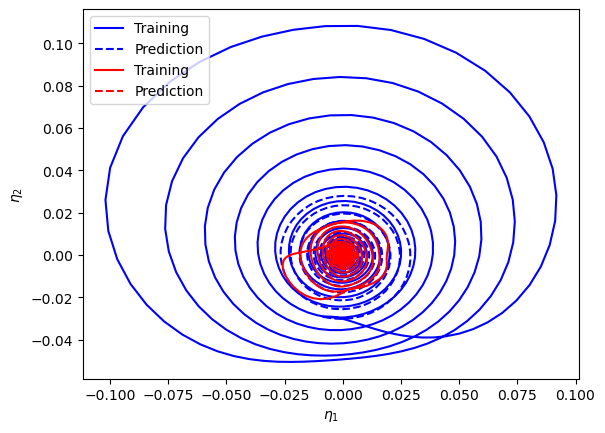

In [477]:
clit=1
for t in trajectories:
    if clit==1:
        transformed = trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='blue', label = 'Training')
        ic = transformed[:,0]
    
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='blue', label = 'Prediction')
        clit+=1
    elif clit==2:
        transformed = trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='red', label = 'Training')
        ic = transformed[:,0]
    
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='red', label = 'Prediction')
        clit+=1
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.legend()

## Increasing the order of approximation

We now compare the results with order = ${3,5,7,9}$

In [141]:
import logging


In [142]:
#to remove the ridge regression txt info
logger = logging.getLogger("ridge_regression")
logger.setLevel(logging.WARNING)

Order: 3, Residual: 0.02258181418517849 



/home/tf/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.34067e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Order: 5, Residual: 0.00035298959223840665 



ValueError: The normal form is not applicable. All eigenvalues need to be complex

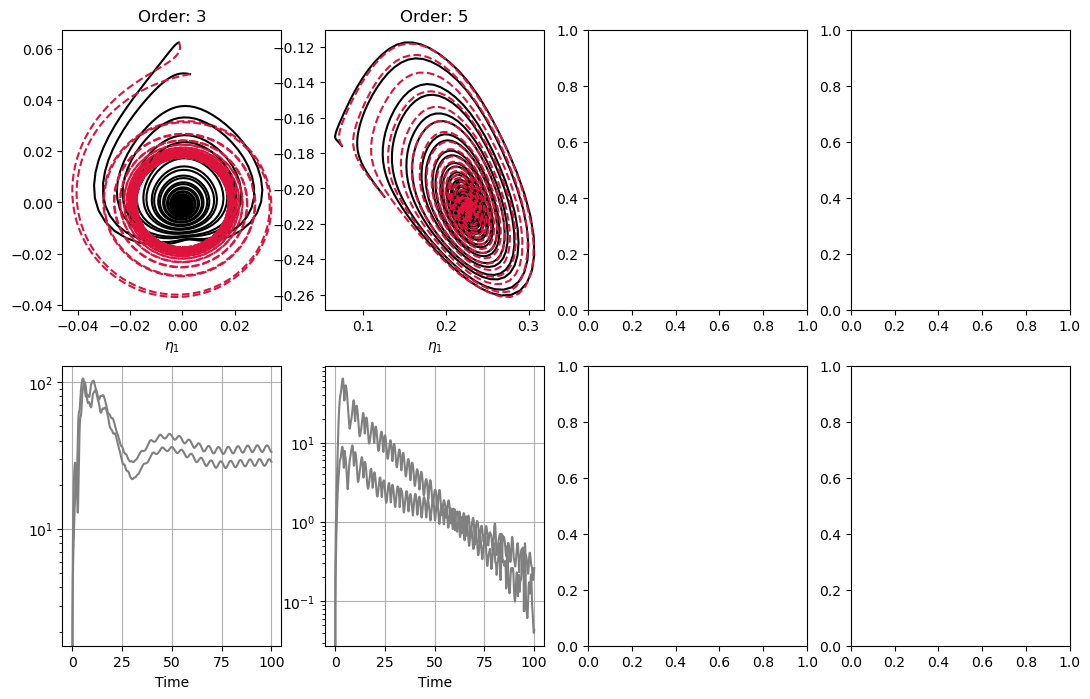

In [238]:
f,ax = plt.subplots(2,4,figsize = (13, 8))
orders = [3, 5, 7]
n_orders = len(orders)
for i in range(n_orders):
    order = orders[i]
    mdl = ridge.get_fit_ridge(X, y, poly_degree = order, constraints = cons) # pre-fit with regular ridge regression
    linearPart = mdl.map_info['coefficients'][:,:2]

    nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = order)
    initial_guess = normalform.create_normalform_initial_guess(mdl, nf)
    res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')
    print('Order: %s, Residual: %s \n' %(order, res.cost))
    d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)
    trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, order, d )
    ax[0,i].set_xlabel('$\\eta_1$')
    ax[0,i].set_title('Order: %s' %order)
    for t in trajectories:
        transformed = trf.inverse_transform(t)
        ax[0,i].plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='black', label = 'Training')
        ic = transformed[:,0]
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        ax[0,i].plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='Crimson', label = 'Prediction')
        ## we also compute the error along trajectories
        tonorm = np.max(np.abs(transformed[:,0]))
        error = np.abs(pred.y[0,:] - transformed[0,:])/tonorm
        ax[1,i].semilogy(pred.t, error*100, '-', c='grey', label ='Relative error')
            
    ax[1,i].grid()  
    ax[1,i].set_xlabel('Time')
ax[0,0].set_ylabel('$\\eta_2$')
ax[1,0].set_ylabel('Relative error [%]')

